<a href="https://colab.research.google.com/github/Diechi09/AI-Machine-Learning-Foundations/blob/main/Assignment2_DiegoOliveros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(17379, 17)
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data column

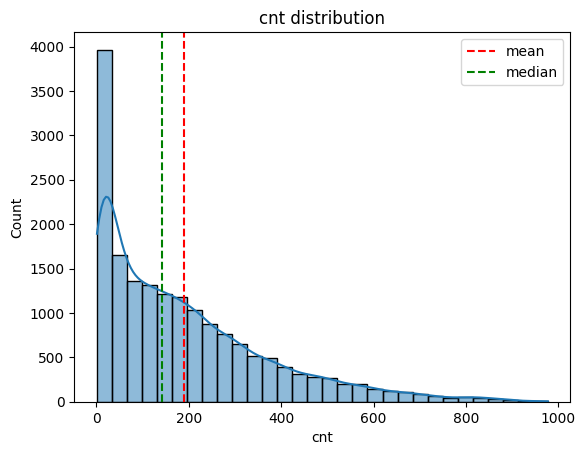

Skew: 1.2774116037490577


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Get the data in
df = pd.read_csv('hour.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Check target variable (cnt)
sns.histplot(df['cnt'], bins=30, kde=True)
plt.axvline(df['cnt'].mean(), color='red', linestyle='--', label='mean')
plt.axvline(df['cnt'].median(), color='green', linestyle='--', label='median')
plt.legend()
plt.title('cnt distribution')
plt.show()

print("Skew:", df['cnt'].skew())


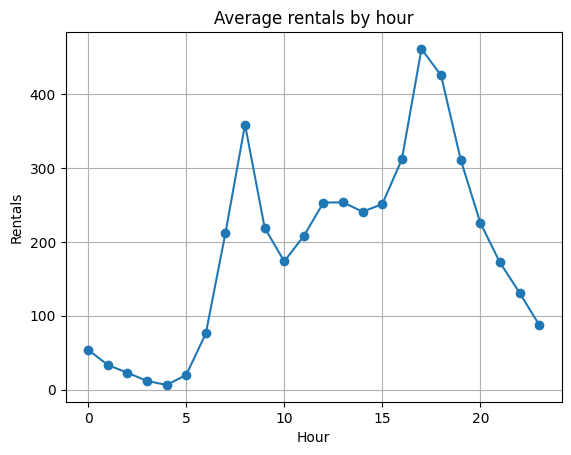

In [2]:
by_hour = df.groupby('hr')['cnt'].mean()

plt.plot(by_hour.index, by_hour.values, marker='o')
plt.title('Average rentals by hour')
plt.xlabel('Hour')
plt.ylabel('Rentals')
plt.grid(True)
plt.show()


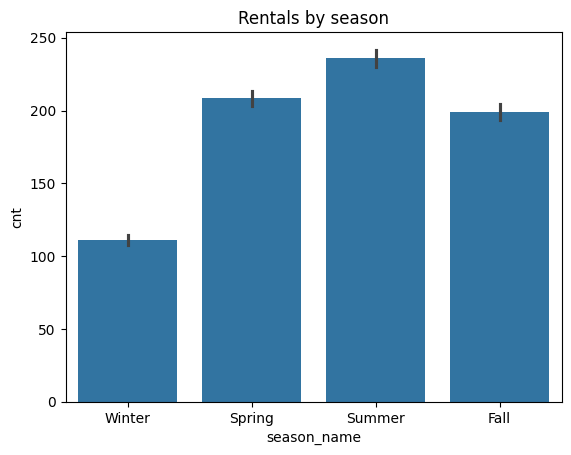

In [3]:
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['season'].map(season_map)

sns.barplot(x='season_name', y='cnt', data=df)
plt.title('Rentals by season')
plt.show()


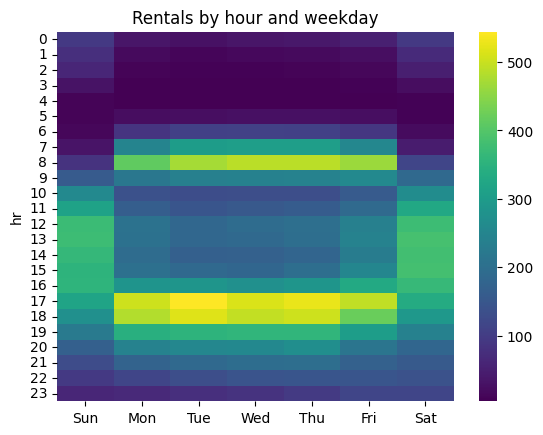

In [4]:
day_map = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
pivot = df.pivot_table(index='hr', columns='weekday', values='cnt', aggfunc='mean')
pivot.columns = [day_map[i] for i in pivot.columns]

sns.heatmap(pivot, cmap='viridis')
plt.title('Rentals by hour and weekday')
plt.show()


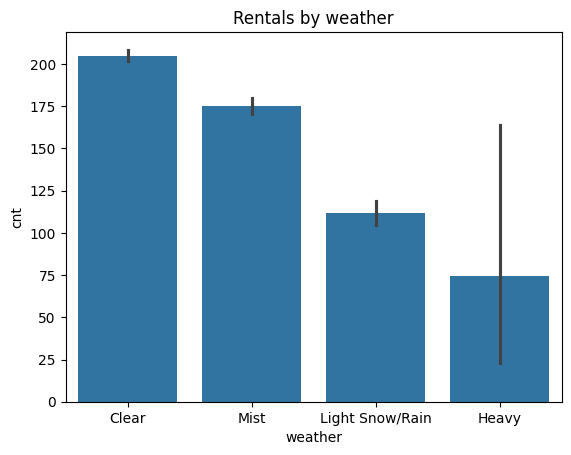

In [5]:
weather_map = {1: 'Clear', 2: 'Mist', 3: 'Light Snow/Rain', 4: 'Heavy'}
df['weather'] = df['weathersit'].map(weather_map)

sns.barplot(x='weather', y='cnt', data=df)
plt.title('Rentals by weather')
plt.show()


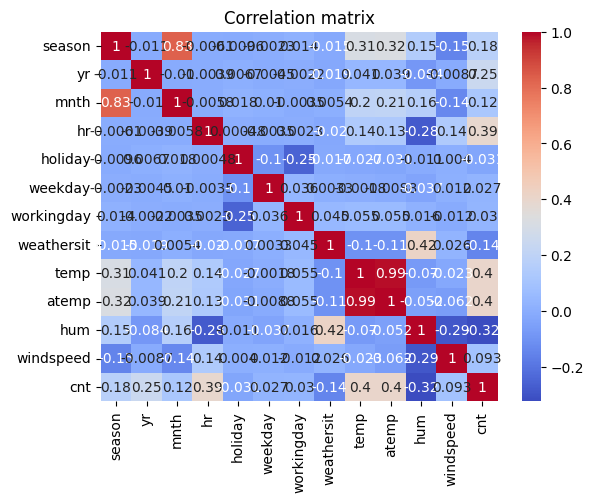

Temp vs Atemp correlation: 0.9876721390396437


In [6]:
cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
corr = df[cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

print("Temp vs Atemp correlation:", corr.loc['temp', 'atemp'])


In [7]:
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])


TASK 2

In [8]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop('cnt', axis=1)
y = df['cnt']

# First split: 80% temp train + val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: split temp set into 75% train, 25% val => (60/20/20)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Show sizes
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (10427, 14), Val: (3476, 14), Test: (3476, 14)


TASK 3

In [9]:
def add_time_feats(df):
    df = df.copy()
    df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
    df['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    return df

X_train = add_time_feats(X_train)
X_val = add_time_feats(X_val)
X_test = add_time_feats(X_test)

X_train['temp_hum'] = X_train['temp'] * X_train['hum']
X_val['temp_hum'] = X_val['temp'] * X_val['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

X_train['weathersit'] = X_train['weathersit'].replace(4, 3)
X_val['weathersit'] = X_val['weathersit'].replace(4, 3)
X_test['weathersit'] = X_test['weathersit'].replace(4, 3)

X_train = X_train.drop('atemp', axis=1)
X_val = X_val.drop('atemp', axis=1)
X_test = X_test.drop('atemp', axis=1)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_features = ['season', 'mnth', 'weathersit']
num_features = ['temp', 'hum', 'windspeed']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
], remainder='passthrough')


In [14]:
preprocessor.fit(X_train)


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['season', 'mnth', 'weathersit']),
                                ('num', StandardScaler(),
                                 ['temp', 'hum', 'windspeed'])])

TASK 4

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import time

# Clean up any leftover EDA string cols like 'season_name' or 'weather'
for col in ['season_name', 'weather']:
    for d in [X_train, X_val, X_test]:
        if col in d.columns:
            d.drop(columns=col, inplace=True)

lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])



start = time.time()
lr_pipeline.fit(X_train, y_train)
print(f"Training time: {time.time() - start:.2f}s")


Training time: 0.07s


In [18]:
y_train_pred = lr_pipeline.predict(X_train)
y_val_pred = lr_pipeline.predict(X_val)


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{label} Metrics")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_train, y_train_pred, 'Train')
print_metrics(y_val, y_val_pred, 'Val')



Train Metrics
MSE: 16227.14
RMSE: 127.39
MAE: 93.02
R²: 0.5146
MAPE: 272.99%

Val Metrics
MSE: 15185.34
RMSE: 123.23
MAE: 90.52
R²: 0.5330
MAPE: 243.20%


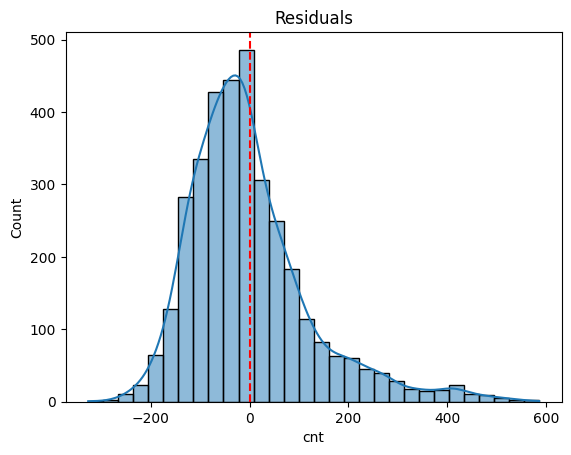

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_val - y_val_pred

sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.show()


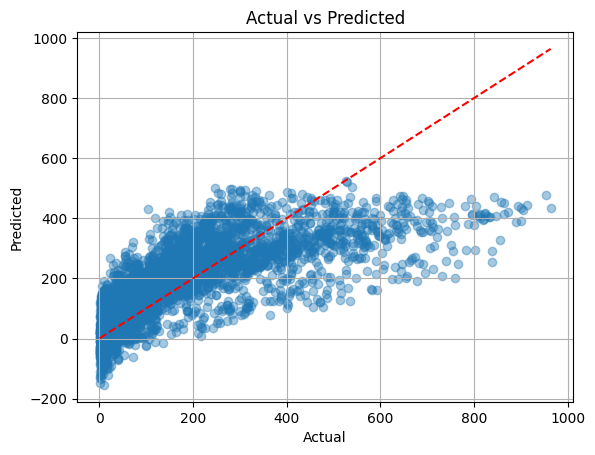

In [21]:
plt.scatter(y_val, y_val_pred, alpha=0.4)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()


TASK 5

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Build pipeline
rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_train_pred_rf = rf_pipeline.predict(X_train)
y_val_pred_rf = rf_pipeline.predict(X_val)


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def print_metrics(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{label} Metrics")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_val, y_val_pred_rf, 'Random Forest - Val')



Random Forest - Val Metrics
MSE: 1903.28
RMSE: 43.63
MAE: 26.84
R²: 0.9415
MAPE: 30.06%


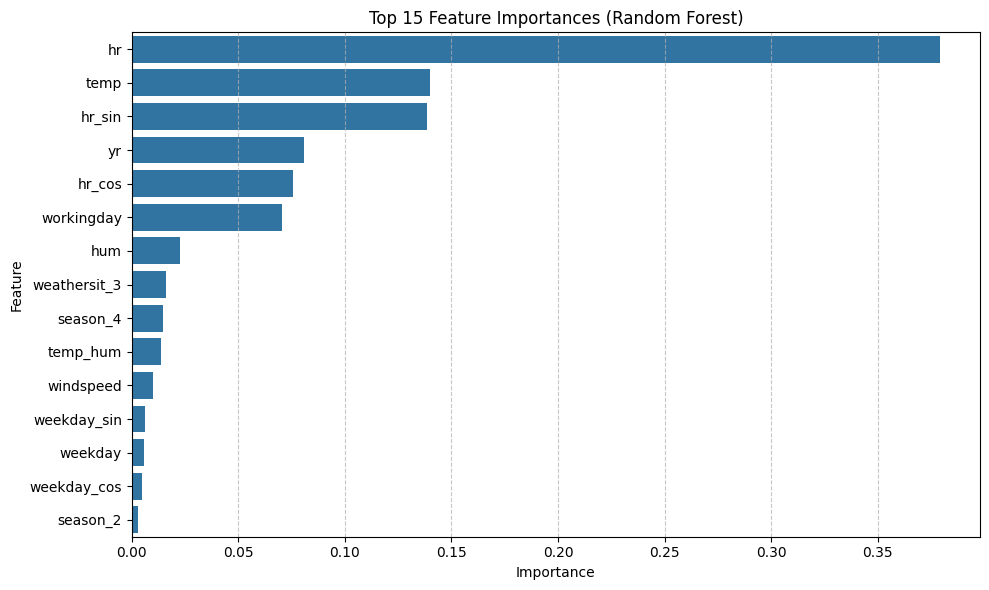

In [28]:
# Grab the trained model (already fit from rf_pipeline)
rf_model = rf_pipeline.named_steps['rf']

# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat']
cat_names = []
for i, col in enumerate(['season', 'mnth', 'weathersit']):
    categories = cat_encoder.categories_[i][1:]  # drop='first'
    cat_names += [f"{col}_{cat}" for cat in categories]

num_names = ['temp', 'hum', 'windspeed']
passthrough_names = [col for col in X_train.columns if col not in ['season', 'mnth', 'weathersit'] + num_names]
all_feature_names = cat_names + num_names + passthrough_names

# Plot
importances = rf_model.feature_importances_
imp_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title('Top 15 Feature Importances (Random Forest)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Task 6

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

# Build basic GB pipeline
gb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Train
gb_pipeline.fit(X_train, y_train)

# Predict
y_train_pred_gb = gb_pipeline.predict(X_train)
y_val_pred_gb = gb_pipeline.predict(X_val)


In [27]:
def print_metrics(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{label} Metrics")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_val, y_val_pred_gb, 'Gradient Boosting - Val')



Gradient Boosting - Val Metrics
MSE: 4817.62
RMSE: 69.41
MAE: 47.41
R²: 0.8518
MAPE: 114.08%


TASK 7

In [29]:
param_dist_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

In [30]:
from sklearn.model_selection import RandomizedSearchCV

rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [31]:
search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['season',
                                                                                'mnth',
                                                                                'weathersit']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['temp',
                                                                                'hum',
                                                                                'windspeed'])])),
                                             ('rf',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'rf__max_depth': [10, 20, 30, None],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [32]:
best_rf_model = search_rf.best_estimator_
print("Best RF params:", search_rf.best_params_)

y_val_pred_rf_best = best_rf_model.predict(X_val)
print_metrics(y_val, y_val_pred_rf_best, "Tuned RF - Val")

Best RF params: {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 30}

Tuned RF - Val Metrics
MSE: 1877.59
RMSE: 43.33
MAE: 26.55
R²: 0.9423
MAPE: 29.96%


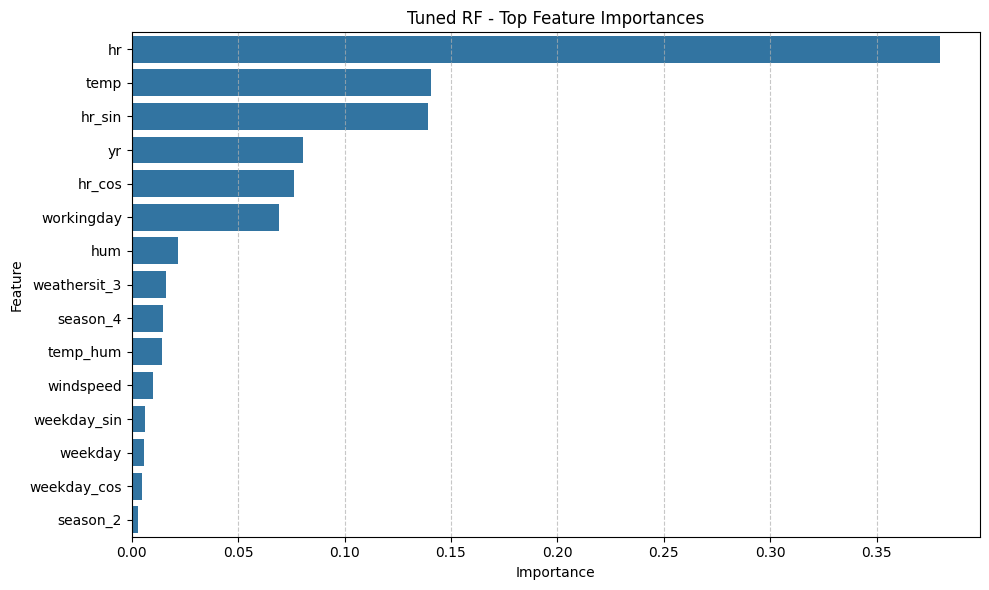

In [33]:
rf_best = best_rf_model.named_steps['rf']
importances = rf_best.feature_importances_

imp_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
imp_df = imp_df.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title('Tuned RF - Top Feature Importances')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


XGB

In [37]:
!pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Integer

gb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('gb', GradientBoostingRegressor(random_state=42))
])

search_gb = BayesSearchCV(
    gb_pipeline,
    search_spaces={
        'gb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'gb__n_estimators': Integer(100, 500),
        'gb__max_depth': Integer(3, 10),
        'gb__subsample': Real(0.5, 1.0)
    },
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.3 MB/s eta 0:00:00


In [38]:
search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('cat',
                                                                          OneHotEncoder(drop='first',
                                                                                        handle_unknown='ignore'),
                                                                          ['season',
                                                                           'mnth',
                                                                           'weathersit']),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          ['temp',
                                                                           'hum',
                                                                           'windspeed'])])),
                                        ('gb',
                                         GradientBoostingRegressor(random_state=42))]),
              n_iter=30, n_jobs=-1, random_state=42,
              scoring...,
              search_spaces={'gb__learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'gb__max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'gb__n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'gb__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [39]:
print("Best GB params:", search_gb.best_params_)

best_gb_model = search_gb.best_estimator_
y_val_pred_gb_best = best_gb_model.predict(X_val)
print_metrics(y_val, y_val_pred_gb_best, "Tuned GB - Val")

Best GB params: OrderedDict([('gb__learning_rate', 0.03529489592331792), ('gb__max_depth', 8), ('gb__n_estimators', 453), ('gb__subsample', 0.5)])

Tuned GB - Val Metrics
MSE: 1512.80
RMSE: 38.89
MAE: 23.46
R²: 0.9535
MAPE: 29.29%


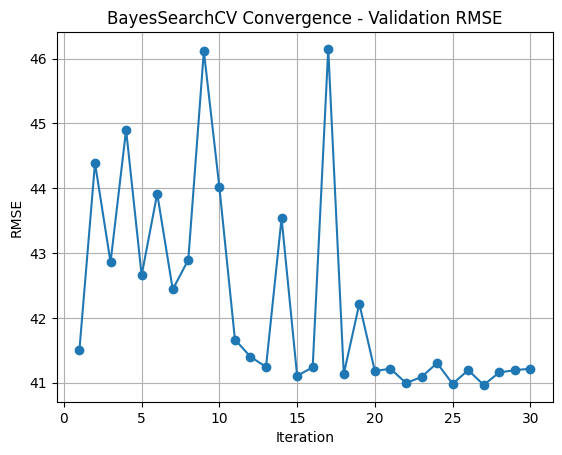

In [43]:
results = search_gb.cv_results_
mean_scores = -results['mean_test_score']  # negate because scores are negative RMSE

plt.plot(range(1, len(mean_scores) + 1), mean_scores, marker='o')
plt.title('BayesSearchCV Convergence - Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()
